# Titanic Survival Prediction
**Author:** Omodariola Abiola 
**Goal:** Predict passenger survival on the Titanic using classic feature engineering and machine learning.  
**Highlights:** Baseline model, feature engineering (Titles, HasCabin), model comparison (Logistic Regression vs Random Forest), cross-validation, and a saved model for inference.

In [15]:
# Cell 1: Imports (core libraries)
# ------------------------------------------------------------
# pandas: the primary library used for tabular data manipulation (DataFrame).
# matplotlib.pyplot: basic plotting library for exploratory data analysis (EDA).
import pandas as pd                # DataFrame handling, CSV I/O, grouping, merging, etc.
import matplotlib.pyplot as plt    # Plotting (histograms, scatterplots, bar charts)




## Dataset
Brief description of train.csv and test.csv (source: Kaggle Titanic dataset).

In [17]:
# Cell 2: Load dataset(s)
# ------------------------------------------------------------
# Load training and test sets. Adjust the file paths to be relative (for portability),
# e.g., 'data/train.csv' and 'data/test.csv', and add error handling in case the files
# are not found (important when sharing repo with others).



import os
train_path = "C:/Users/Dell/Documents/titanic/train.csv"
test_path = "C:/Users/Dell/Documents/titanic/test.csv"

# Defensive loading with helpful error message if path is wrong:
if not os.path.exists(train_path):
    raise FileNotFoundError(f"Training file not found at {train_path}. "
                            "Please update path to local 'train.csv' or place it in data/ directory.")

df = pd.read_csv(train_path)       # Primary training DataFrame (contains features + target 'Survived')
df.head()                          # Quick peek at the top rows — shows structure, columns, dtypes

# Load test set (usually used for final predictions on Kaggle)
test_data = pd.read_csv(test_path)
# test_data.head()  # Uncomment to preview test set


## Exploratory Data Analysis
Visualizations, missing value analysis, and notes to support design choices.

In [18]:
# Cell 3: Initial EDA — shape, dtypes, missing values overview
# ------------------------------------------------------------
# This cell should provide a concise summary of the dataset:
# - number of rows and columns
# - column names and dtypes
# - count of missing values per column
# - summary statistics for numeric columns

# Replace the placeholder '...' with the following:

# Basic dataset size and preview
print("Train shape:", df.shape)
print("Test shape:", test_data.shape)

# Column info (names and dtypes)
print("\nColumn datatypes and non-null counts:")
display(df.info())   # info() prints summary; display makes it notebook-friendly

# Missing value counts per column (descending)
missing_counts = df.isnull().sum().sort_values(ascending=False)
print("\nMissing values (train):")
print(missing_counts[missing_counts > 0])

# Basic statistics (numeric)
print("\nNumeric summary statistics:")
display(df.describe())

# For quick class balance check of target 'Survived'
if 'Survived' in df.columns:
    print("\nTarget class distribution (Survived):")
    print(df['Survived'].value_counts(normalize=False))
    print("\nTarget class proportions:")
    print(df['Survived'].value_counts(normalize=True))


Train shape: (891, 12)
Test shape: (418, 11)

Column datatypes and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None


Missing values (train):
Cabin       687
Age         177
Embarked      2
dtype: int64

Numeric summary statistics:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200



Target class distribution (Survived):
Survived
0    549
1    342
Name: count, dtype: int64

Target class proportions:
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


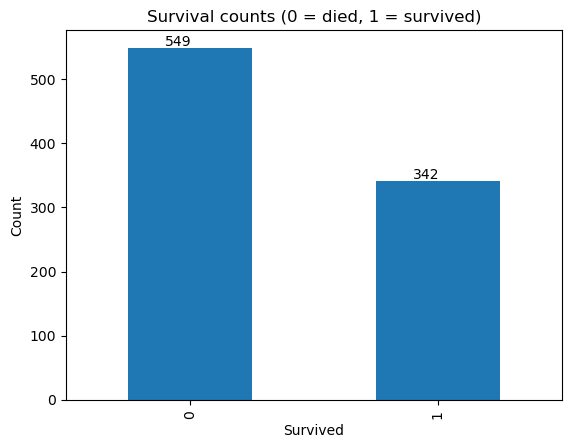

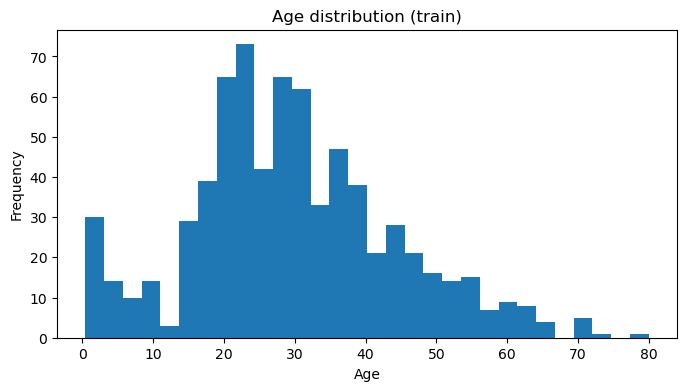


Survival rate by Sex:


Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [19]:
# Cell 4: Visual EDA — target distribution and a few feature plots
# ------------------------------------------------------------
# Visualizations help explain patterns in the data. Keep visuals simple and annotated.

# 1) Plot distribution of the target (Survived)
if 'Survived' in df.columns:
    ax = df['Survived'].value_counts().plot(kind='bar')
    ax.set_title('Survival counts (0 = died, 1 = survived)')
    ax.set_xlabel('Survived')
    ax.set_ylabel('Count')
    for p in ax.patches:
        ax.annotate(int(p.get_height()), (p.get_x() + 0.15, p.get_height() + 3))
    plt.show()

# 2) Age distribution (histogram)
if 'Age' in df.columns:
    plt.figure(figsize=(8,4))
    plt.hist(df['Age'].dropna(), bins=30)  # dropna() to avoid plotting NaNs
    plt.title('Age distribution (train)')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.show()

# 3) Survival rate by Sex (useful categorical pivot)
if set(['Sex','Survived']).issubset(df.columns):
    print("\nSurvival rate by Sex:")
    display(df.groupby('Sex')['Survived'].mean().sort_values(ascending=False))


In [20]:
# Cell 5: Clean column names & initial feature selection rationale
# ------------------------------------------------------------
# Keep column names consistent and document which features you will use.
# Typical Titanic columns: ['PassengerId','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked','Survived']

# Standardize column names 
df.columns = [c.strip() for c in df.columns]
test_data.columns = [c.strip() for c in test_data.columns]

# Feature groups
features_all = df.columns.tolist()
target = 'Survived' if 'Survived' in df.columns else None

print("All features:", features_all)
print("Target:", target)

# Decide on features to keep for baseline model — explain reasoning:
# - Keep: Pclass (socio-economic class), Sex (strong predictor historically), Age (survival likelihood),
#         SibSp/Parch (family size), Fare (ticket price), Embarked (port) 
# - Drop or postpone: Name (requires name-based feature extraction), Ticket (messy),
#                     Cabin (many missing values)
baseline_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
print("\nBaseline features selected:", baseline_features)


All features: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
Target: Survived

Baseline features selected: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


In [21]:
# 🧹 Handling Missing Values in Both Train and Test Datasets

# Fill missing values in the 'Age' column with the median age.
# Using the median is more robust to outliers than the mean and keeps the central tendency of the data.
df["Age"].fillna(df["Age"].median(), inplace=True)
test_data["Age"].fillna(test_data["Age"].median(), inplace=True)

# Fill missing values in the 'Fare' column with the median fare.
# This ensures all rows have valid fare values, which is important since the 'Fare' feature can influence survival prediction.
df["Fare"].fillna(df["Fare"].median(), inplace=True)
test_data["Fare"].fillna(test_data["Fare"].median(), inplace=True)

# Fill missing values in the 'Embarked' (port of embarkation) column with the mode (most frequent value).
# Categorical features are best filled using the mode, as it preserves the most common category distribution.
df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)
test_data["Embarked"].fillna(test_data["Embarked"].mode()[0], inplace=True)

# ✅ Summary:
# This step ensures there are no missing values in critical columns before encoding or model training.
# It improves data quality and prevents errors during machine learning model fitting.


C:\Users\Dell\AppData\Local\Temp\ipykernel_8100\2714563492.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Age"].fillna(df["Age"].median(), inplace=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_8100\2714563492.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

## Feature Engineering & Preprocessing
Explain all engineered features, imputations, encodings, and scaling choices.


In [22]:
# Create a new feature 'FamilySize' by summing the number of siblings/spouses and parents/children aboard, plus 1 for the passenger themselves
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
test_data["FamilySize"] = test_data["SibSp"] + test_data["Parch"] + 1

# Create a binary feature 'IsAlone': 1 if the passenger is alone (FamilySize == 1), otherwise 0
df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
test_data["IsAlone"] = (test_data["FamilySize"] == 1).astype(int)

## Modeling
Baseline models attempted

In [23]:
from sklearn.ensemble import RandomForestClassifier  # Import the Random Forest classifier from scikit-learn

y = df["Survived"]  # Define the target variable (labels) from the training data

# Select features to use for training the model
features = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "IsAlone"]

# Convert categorical variables into dummy/indicator variables for both training and test sets
X = pd.get_dummies(df[features])
X_test = pd.get_dummies(test_data[features])

# Ensure both training and test sets have the same columns by aligning them
X, X_test = X.align(X_test, join="left", axis=1, fill_value=0)

# Initialize the Random Forest model with 100 trees, max depth of 5, and a fixed random seed for reproducibility
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)

# Train the model using the training data
model.fit(X, y)

# Make predictions on the test set
predictions = model.predict(X_test)

# Create a DataFrame with PassengerId and predicted Survived values
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})

# Save the predictions to a CSV file for submission
output.to_csv('submission.csv', index=False)

# Cross-Validation
Cross-validation helps us evaluate how well the model generalizes to unseen data. We'll use Stratified K-Fold to preserve the class distribution of Survived.


In [24]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Set up stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Evaluate model using cross-validation
scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

# Print average accuracy
print(f"Cross-validated accuracy: {scores.mean():.4f}")

Cross-validated accuracy: 0.8215


# Hyperparameter Tuning
Let’s use GridSearchCV to find the best combination of parameters for the Random Forest.


In [25]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Set up GridSearch with cross-validation
grid_search = GridSearchCV(RandomForestClassifier(random_state=1),
                           param_grid,
                           cv=cv,
                           scoring='accuracy',
                           n_jobs=-1)

# Fit to training data
grid_search.fit(X, y)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print(f"Best cross-validated accuracy: {grid_search.best_score_:.4f}")

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
67 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
  

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validated accuracy: 0.8283


# Retrain with Best Parameters
Once you find the best parameters, retrain your model and generate predictions again:


In [14]:
# Use best estimator from grid search
best_model = grid_search.best_estimator_

# Fit and predict
best_model.fit(X, y)
predictions = best_model.predict(X_test)

# Save new predictions
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission_tuned.csv', index=False)

In [26]:
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


# Final Conclusion
In this project, we developed a machine learning model to predict survival outcomes on the Titanic using a Random Forest Classifier. Starting with thoughtful feature engineering — including FamilySize and IsAlone — we enhanced the dataset to capture social and relational dynamics that influence survival. After preprocessing and aligning the training and test sets, we trained the model and generated initial predictions.
To improve performance and ensure robustness, we implemented Stratified K-Fold cross-validation and GridSearchCV for hyperparameter tuning. These steps allowed us to evaluate the model more reliably and identify the best configuration for generalization. The final model, trained with optimized parameters, produced refined predictions ready for submission.
This workflow demonstrates a complete machine learning pipeline: from data preparation and feature engineering to model evaluation and deployment. It highlights the importance of iterative refinement and validation in building trustworthy predictive systems.


